In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, confusion_matrix
from scipy import signal

import torch
import torch.nn as nn
import torch.nn.functional as f

import fastai2 
from fastai2.data.core import DataLoaders
from fastai2.vision.all import *

print("Pytorch:", torch.__version__)
print("Fastai2:", fastai2.__version__)

Pytorch: 1.5.0
Fastai2: 0.0.17


In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #tf.random.set_seed(seed) # Tensorflow

# Data

In [3]:
train = pd.read_csv('data/train_clean.csv', dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})
test  = pd.read_csv('data/test_clean.csv',  dtype={'time': np.float32, 'signal': np.float32})
sub   = pd.read_csv('data/sample_submission.csv', dtype={'time': np.float32})

train_groups = np.load("data/train_groups.npy")
test_groups  = np.load("data/test_groups.npy")
train["group"] = train_groups
test["group"]  = test_groups
test["open_channels"] = 0 # CHAPUZA para ahorrar codigo

In [4]:
train_groups

array([0, 0, 0, ..., 3, 3, 3], dtype=int8)

In [5]:
train0 = train[      0: 500000]
train1 = train[ 500000:1000000]
train2 = train[1000000:1500000]
train3 = train[1500000:2000000]
train4 = train[2000000:2500000]
train5 = train[2500000:3000000]
train6 = train[3000000:3500000]
train7 = train[3500000:4000000]
train8 = train[4000000:4500000]
train9 = train[4500000:5000000]

In [6]:
test.head(2)

,time,signal,group,open_channels
0,500.000092,-2.649832,0,0
1,500.000214,-2.849463,0,0


# DataLoader
- Poner onhot grupo en entrada
- Agumatation
  - Leer a la inversa

In [7]:
# TODO: Add data batch id
# TODO: 2D fetaures (scalogram...)

class DS(torch.utils.data.Dataset):
    def __init__(self, df, win_size):
        self.win_size  = win_size
        self.array_x   = np.pad(df["signal"].values, pad_width=win_size//2, mode='edge')
        self.array_g   = df["group"].values
        self.array_y   = df["open_channels"].values
        #self.scalogram = signal.cwt(data=df["signal"].values, wavelet=signal.ricker, widths=np.arange(1, 31))
        
    def __len__(self):
        return len(self.array_y)
    
    def __getitem__(self, i):
        window    = torch.tensor(self.array_x[ i : i+self.win_size ])
        #scalogram = torch.tensor(self.scalogram[:,i]).float() # array of 30
        group     = torch.tensor(self.array_g[i],  dtype=torch.int64)
        group_oh  = F.one_hot(group, num_classes=5).float()
        x = torch.cat([group_oh, window]) # scalogram
        y = torch.tensor(self.array_y[i], dtype=torch.long)
        return (x, y)

In [8]:
#g5toy_train = DS(train4[:100000], win_size=7)
#g5toy_valid = DS(train9[:100000], win_size=7)

#g5big_train = DS(train4, win_size=7)
#g5big_valid = DS(train9, win_size=7)

m = 10000
#toy_train = DS(pd.concat([train0[:m], train2[:m], train7[:m], train5[:m], train4[:m]]), win_size=7)
#toy_valid = DS(pd.concat([train1[:m], train6[:m], train3[:m], train8[:m], train9[:m]]), win_size=7)

half_train = DS(pd.concat([train0, train2, train7, train5, train9]), win_size=7)
half_valid = DS(pd.concat([train1, train6, train3, train8, train4]), win_size=7)

#all_train = DS(train, win_size=7)

test_ds  = DS(test, win_size=7)

In [9]:
BS = 512#256
#dls_g5toy = DataLoaders.from_dsets(g5toy_train, g5toy_valid, test_ds, bs=BS, device=torch.device("cuda"))
#dls_g5big = DataLoaders.from_dsets(g5big_train, g5big_valid, test_ds, bs=BS, device=torch.device("cuda"))
#dls_toy   = DataLoaders.from_dsets(toy_train,   toy_valid,   test_ds, bs=BS, device=torch.device("cuda"))
dls_half  = DataLoaders.from_dsets(half_train,  half_valid,  test_ds, bs=4000)#, device=torch.device("cuda"))
#dls_all   = DataLoaders.from_dsets(all_train,   toy_valid,   test_ds, bs=4000, device=torch.device("cuda"))

# Model

In [10]:
# TODO: ReLU , BatchNorm, Dropout

class Net7(nn.Module):
    def __init__(self):
        super(Net7, self).__init__()
        
        ################### FEATURE EXTRACTOR: 80 feats
        self.bn_win = nn.BatchNorm1d(7)
        #self.bn_sca = nn.BatchNorm1d(30)
        self.li = nn.Linear(in_features=1,  out_features=8)
        self.c1 = nn.Conv1d(in_channels=1,  out_channels=32, kernel_size=3); self.bn1 = nn.BatchNorm1d(32)
        self.c2 = nn.Conv1d(in_channels=32, out_channels=24, kernel_size=3); self.bn2 = nn.BatchNorm1d(24)
        self.c3 = nn.Conv1d(in_channels=24, out_channels=16, kernel_size=3);
        self.relu = nn.ReLU(inplace=True)
        
        self.bn_feats = nn.BatchNorm1d(80)
        
        ################### CLASSIFIER: Dense 85->128->11
        self.d1 = nn.Linear(in_features=85,  out_features=128)
        self.bn_d1 = nn.BatchNorm1d(128)
        self.d2 = nn.Linear(in_features=128, out_features=11)

        
    def forward(self, x): # ENTRADA: forma (BS, 5+30+7)  # BS, onehot=11 + win=7
        
        group_oh  = x[:,:5]   # (BS, 5)
        #scalogram = x[:,5:35] # (BS, 30)
        window    = x[:,5:]  # (BS, 7)
        window    = self.bn_win(window)
        #scalogram = self.bn_sca(scalogram)
        center    = window[:,3].unsqueeze(1)
        
        ################### FEATURE EXTRACTOR
        li_final = self.li(center)  # 8 feats
        
        c1_res = self.c1(window.unsqueeze(1));    # CONVERTIR a forma (BS, 1, 7)  # BS, chls=1, len=7    
        c2_res = self.c2(self.relu(self.bn1(c1_res)));
        c3_res = self.c3(self.relu(self.bn2(c2_res)));
        c1_final = c1_res[:,:,2:-2].squeeze() # 32 feats de (k3)        Entrada ventana de 3
        c2_final = c2_res[:,:,1:-1].squeeze() # 24 feats de (k3->k3)    Entrada ventana de 5
        c3_final = c3_res.squeeze()           # 16 feats de (k3->k3-k3) Entrada ventana de 7          
        
        win_feats = torch.cat([li_final, c1_final, c2_final, c3_final], dim=1) # 80 feats
        win_feats = self.bn_feats(win_feats)
        #print(group_oh.dtype, win_feats.dtype, scalogram.dtype)
        feats     = self.relu(torch.cat([group_oh, win_feats], dim=1)) # 5+80+30 feats
        
        ################### CLASSIFIER
        out = self.relu(self.bn_d1(self.d1(feats)))
        out = self.d2(out)
        
        return out
            
net7 = Net7()

In [11]:
net7(torch.randn(2,5+7)).shape

torch.Size([2, 11])

# Weigted class

In [12]:
dls         = dls_half, # dls_toy, dls_half, dls_g5toy, dls_g5big
train_preds = dls[0].array_y

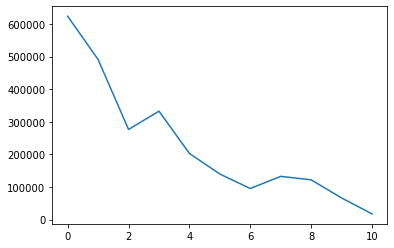

In [13]:
plt.plot(np.bincount(train_preds));

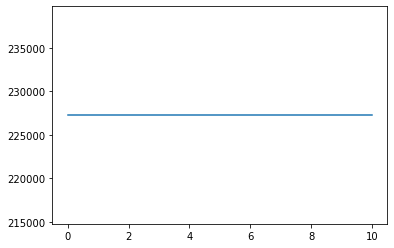

In [14]:
class_weights = np.bincount(train_preds).sum() / (11 * np.bincount(train_preds))
plt.plot(np.bincount(train_preds) * class_weights);

In [15]:
class_weights=torch.FloatTensor(class_weights).cuda()

# Train

In [15]:
# TODO: Weighted by class
# TODO: Better loss for F1 macro??? Focal??
# TODO: Adam, Radam,...
learn = Learner(dls       = dls_half, #dls_half, dls_g5big, dls_g5toy, dls_g5, dls
                model     = net7,
                loss_func = nn.CrossEntropyLoss(weight=None), # F.cross_entropy, CrossEntropyLossFlat(),
                metrics   = [F1Score(average='macro'), accuracy],
                cbs       = ShowGraphCallback())
#learn.summary()

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.010964781977236271)

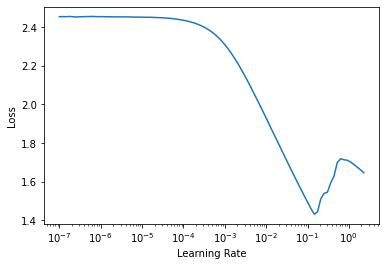

In [17]:
learn.lr_find()

In [18]:
10e-2

0.1

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.112798,0.091649,0.933175,0.965255,02:48
1,0.100538,0.083383,0.936199,0.967920,02:48
2,0.095073,0.078227,0.939260,0.969947,02:48


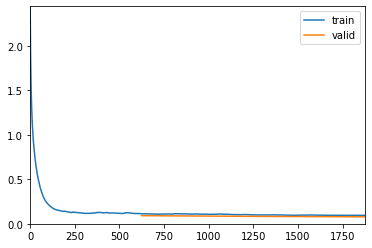

In [19]:
learn.fit_one_cycle(n_epoch=3, lr_max=0.1)

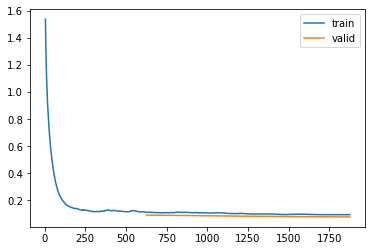

In [20]:
learn.recorder.plot_loss()

# Validación

In [21]:
#interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [22]:
preds,targs = learn.get_preds()

preds = torch.max(preds, 1)[1].numpy()
targs = targs.numpy()
len(preds)

2500000

In [23]:
len(targs)

2500000

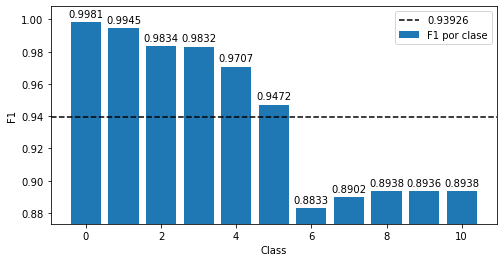

In [24]:
f1 = f1_score(preds, targs, average=None)

plt.figure(figsize=(8, 4))
plt.ylim([min(f1)-0.01, max(f1)+0.01])
plot = plt.bar(list(range(0,11)), f1)
plt.axhline(f1.mean(), color='k', linestyle='--')

for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2., 1.002*height,round(height,4), ha='center', va='bottom')

plt.xlabel("Class")
plt.ylabel("F1")
plt.legend([str(round(f1.mean(),6)),"F1 por clase"])
plt.show()

In [25]:
preds_df = pd.DataFrame({'preds': preds, 'targs': targs})

In [26]:
x_valid = pd.concat([train1, train6, train3, train8, train4])["signal"].values

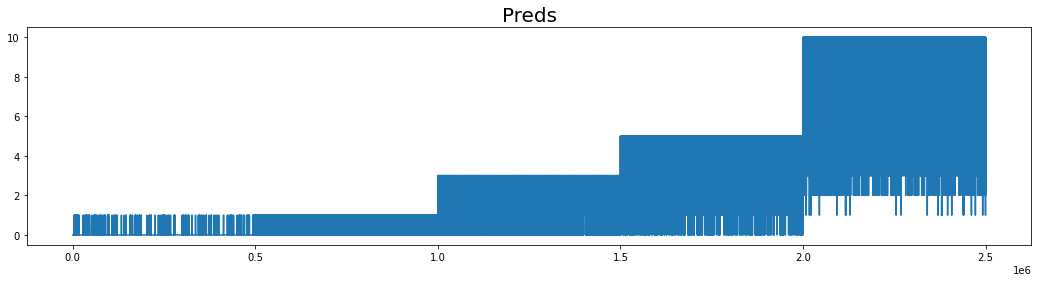

In [27]:
plt.figure(figsize=(18, 4)); plt.plot(preds); plt.title("Preds",fontsize=20);

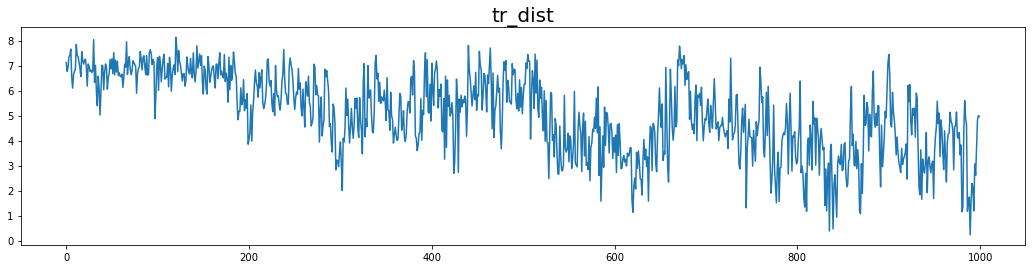

In [28]:
#tr_dist = pd.concat([train0[:m], train2[:m], train7[:m], train5[:m], train4[:m]])["open_channels"].values
tr_dist = train4[:1000]["signal"].values
plt.figure(figsize=(18, 4)); plt.plot(tr_dist); plt.title("tr_dist",fontsize=20);

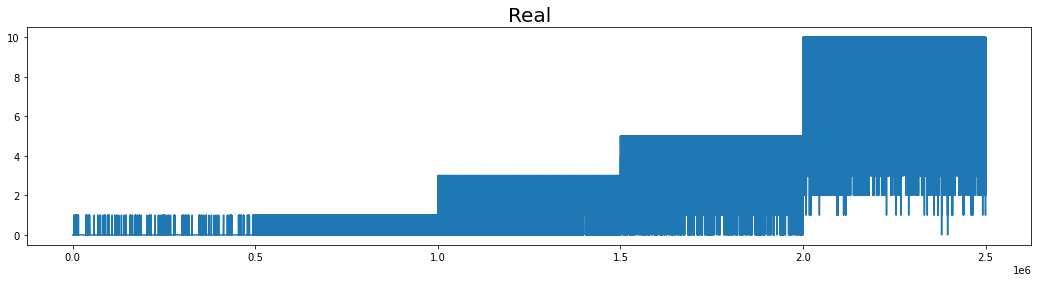

In [29]:
plt.figure(figsize=(18, 4)); plt.plot(targs); plt.title("Real",fontsize=20);

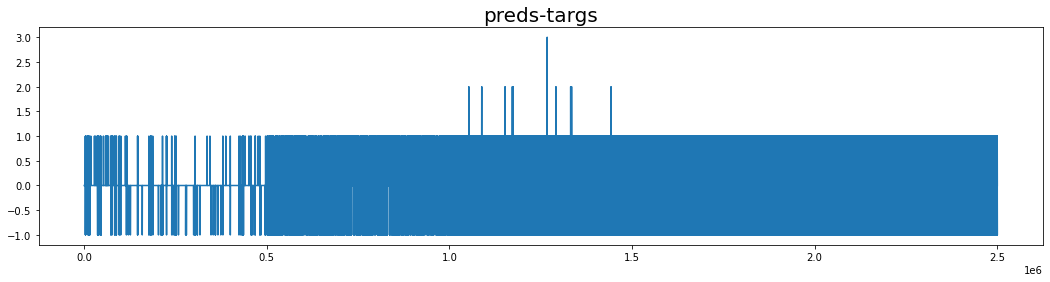

In [30]:
plt.figure(figsize=(18, 4)); plt.plot(preds-targs); plt.title("preds-targs",fontsize=20);

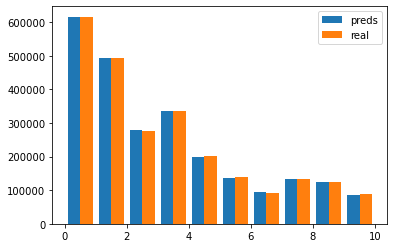

In [31]:
plt.hist([preds, targs], label=['preds', 'real'])
plt.legend(loc='upper right')
plt.show()

In [32]:
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, confusion_matrix

print("Accuracy:    ", accuracy_score(preds, targs))
print("Balanced acc:", balanced_accuracy_score(preds, targs))
print("F1 score:    ", f1_score(preds, targs, average='macro'))
print("Confus mat:\n", confusion_matrix(preds, targs))

Accuracy:     0.9699472
Balanced acc: 0.9399197355505492
F1 score:     0.939259672197225
Confus mat:
 [[615301   1014      0      0      0      0      0      0      0      0
       0]
 [  1292 492162   1339      0      0      0      0      0      0      0
       0]
 [    10   1833 273270   3166      0      0      0      0      0      0
       0]
 [     1      0   2861 330478   2842      0      0      0      0      0
       0]
 [     0      0      0   2425 194532   3364      0      0      0      0
       0]
 [     0      0      0      0   3097 130152   3414      0      0      0
       0]
 [     0      0      0      0      0   4642  82248   6559      0      0
       0]
 [     0      0      0      0      0      0   7117 117893   7543      0
       0]
 [     0      0      0      0      0      0      0   7867 110719   5924
       0]
 [     0      0      0      0      0      0      0      0   4981  61948
    2063]
 [     0      0      0      0      0      0      0      0      0   1778
   161

In [33]:
ran = len(preds) // 5

print("Gr 1 F1", f1_score(preds[ran*0:ran*1], targs[ran*0:ran*1], average='macro'))
print("Gr 2 F1", f1_score(preds[ran*1:ran*2], targs[ran*1:ran*2], average='macro'))
print("Gr 3 F1", f1_score(preds[ran*2:ran*3], targs[ran*2:ran*3], average='macro'))
print("Gr 4 F1", f1_score(preds[ran*3:ran*4], targs[ran*3:ran*4], average='macro'))
print("Gr 5 F1", f1_score(preds[ran*4:ran*5], targs[ran*4:ran*5], average='macro'))

Gr 1 F1 0.9957377283851327
Gr 2 F1 0.9962496261575625
Gr 3 F1 0.9847565179769344
Gr 4 F1 0.9717009716934836
Gr 5 F1 0.7814345017118743


# Test

In [34]:
preds_t,targs_t = learn.get_preds(ds_idx=2)

preds_t = torch.max(preds_t, 1)[1].numpy()
#targs_t.numpy()
preds_t

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
len(preds_t)

2000000

In [37]:
np.save('data/test_preds.npy', preds_t)

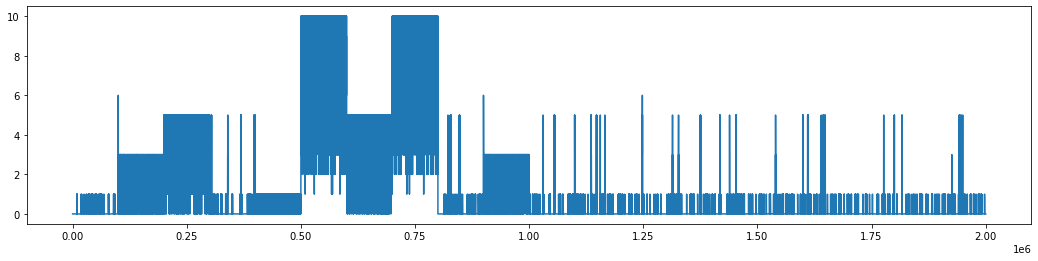

In [36]:
plt.figure(figsize=(18, 4))
plt.plot(preds_t);

In [31]:
t_x01 = test["signal"][      0: 100000].values;   t_p01 = preds_t[      0: 100000];
t_x02 = test["signal"][ 100000: 200000].values;   t_p02 = preds_t[ 100000: 200000];
t_x03 = test["signal"][ 200000: 300000].values;   t_p03 = preds_t[ 200000: 300000];
t_x04 = test["signal"][ 300000: 400000].values;   t_p04 = preds_t[ 300000: 400000];
t_x05 = test["signal"][ 400000: 500000].values;   t_p05 = preds_t[ 400000: 500000];
t_x11 = test["signal"][ 500000: 600000].values;   t_p11 = preds_t[ 500000: 600000];
t_x12 = test["signal"][ 600000: 700000].values;   t_p12 = preds_t[ 600000: 700000];
t_x13 = test["signal"][ 700000: 800000].values;   t_p13 = preds_t[ 700000: 800000];
t_x14 = test["signal"][ 800000: 900000].values;   t_p14 = preds_t[ 800000: 900000];
t_x15 = test["signal"][ 900000:1000000].values;   t_p15 = preds_t[ 900000:1000000];
t_x2  = test["signal"][1000000:1500000].values;   t_p2  = preds_t[1000000:1500000];
t_x3  = test["signal"][1500000:2000000].values;   t_p3  = preds_t[1500000:2000000];

all_t_x = [ t_x01, t_x02, t_x03, t_x04, t_x05, t_x11, t_x12, t_x13, t_x14, t_x15, t_x2, t_x3 ]
all_t_p = [ t_p01, t_p02, t_p03, t_p04, t_p05, t_p11, t_p12, t_p13, t_p14, t_p15, t_p2, t_p3 ]

W: 0.5183332044670766 	B: 1.4225109625948391 	Std: 0.2079097 0.15736485521254798
W: 0.7497992115590056 	B: 2.215884662413222 	Std: 0.760456 0.21392678329114959
W: 0.7667064625316836 	B: 2.306355793855748 	Std: 0.99118865 0.22186136682280141
W: 0.6196299227081222 	B: 1.6985716287285697 	Std: 0.3145626 0.18384993066509864
W: 0.6705128641069124 	B: 1.9559836638872004 	Std: 0.39911664 0.1821545217322758
W: 0.7745606698740035 	B: 4.554742543319935 	Std: 1.4461694 0.2754978790293683
W: 0.7695520340535197 	B: 2.2867823467738924 	Std: 1.0025935 0.2212870199136525
W: 0.7722465511606427 	B: 4.559029351520581 	Std: 1.3962913 0.27558835461007886
W: 0.5538151084413847 	B: 1.5242569660093641 	Std: 0.2466421 0.17006956913804439
W: 0.7447310550609991 	B: 2.213722478950759 	Std: 0.73202705 0.21127614919381152
W: 0.5712398839675447 	B: 1.5770317069955802 	Std: 0.26050815 0.17400787927409864
W: 0.5474186221767947 	B: 1.517505120223626 	Std: 0.24240914 0.17211015161105925


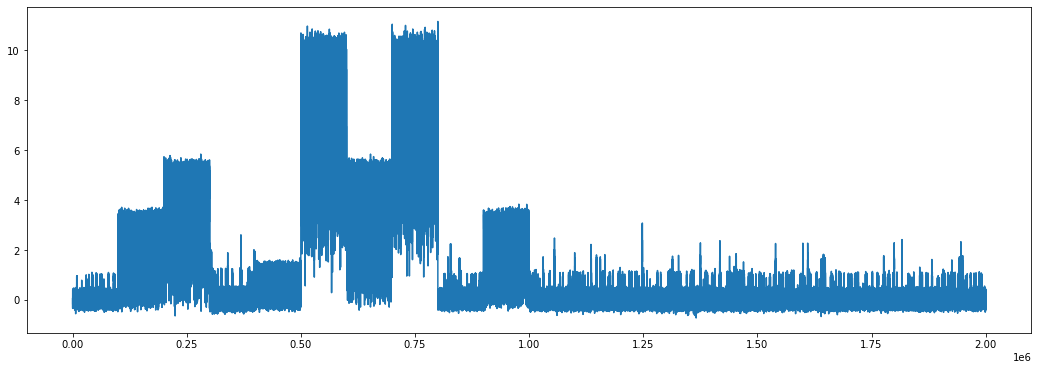

In [37]:
def correct_mae(params):
    w,b = params
    return np.mean(np.abs(y - (x*w + b)))

def correct_mse(params):
    w,b = params
    return np.mean(np.square(y - (x*w + b)))

total_x_corrected = np.array([])
for x, y in zip(all_t_x, all_t_p):
    res = scipy.optimize.minimize(correct_mse, (1.,0), method='Powell')
    w,b = res.x[0], res.x[1]
    x_corrected = x*w + b
    total_x_corrected = np.append(total_x_corrected, x_corrected)
    print("W:",w,"\tB:",b,"\tStd:",x_corrected.std(),(y - x_corrected).std())

plt.figure(figsize=(18, 6)); plt.plot(total_x_corrected);

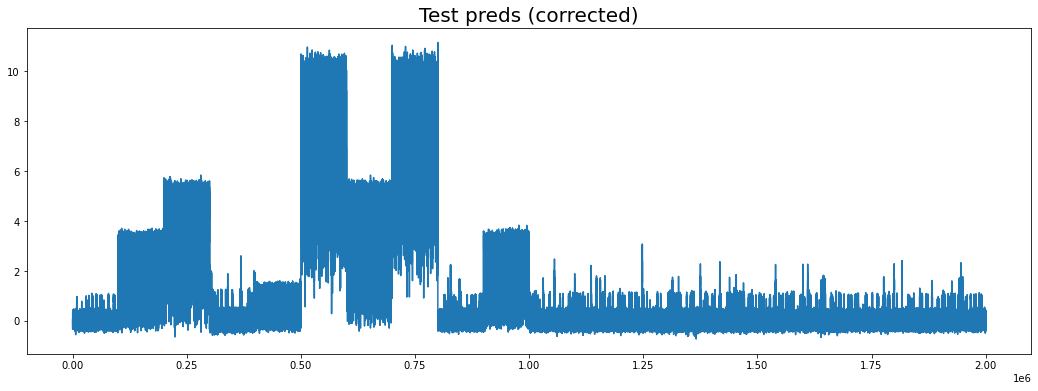

In [51]:
plt.figure(figsize=(18, 6)); plt.plot(total_x_corrected);
plt.title("Test preds (corrected)", fontsize=20);

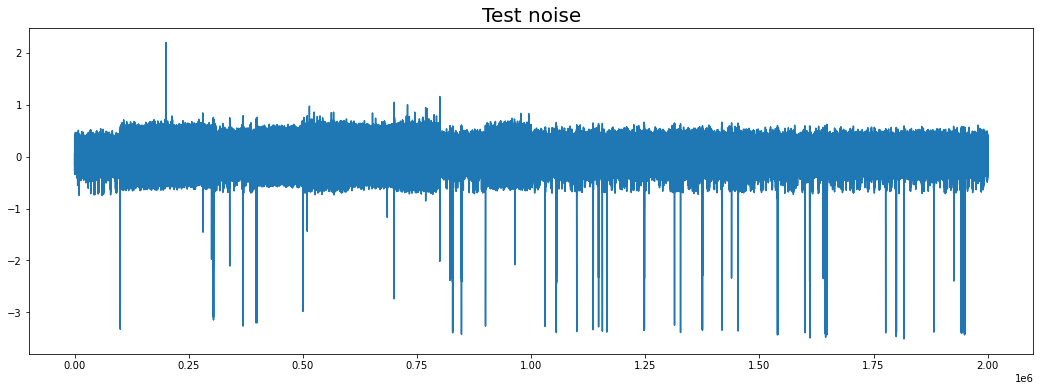

In [49]:
noise = total_x_corrected-preds_t
plt.figure(figsize=(18, 6)); plt.plot(noise);
plt.title("Test noise", fontsize=20);

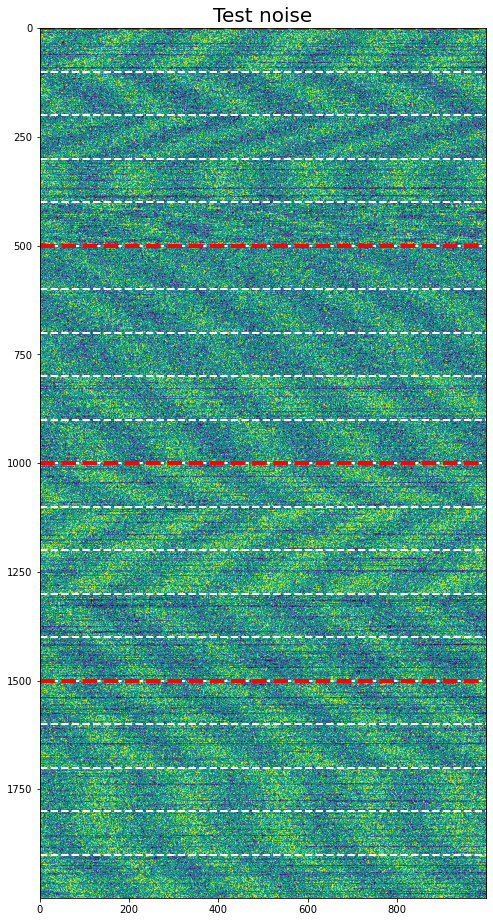

In [52]:
plt.figure(figsize=(8, 16))
plt.imshow(noise.reshape(-1, 1000).clip(-0.02,0.02), aspect='auto')
#[plt.axhline(i, color='k', linestyle='--') for i in range(2000,2500,50)];
[plt.axhline(i, color='w', linestyle='--', linewidth=2) for i in range(0,2000,100)]
[plt.axhline(i, color='r', linestyle='--', linewidth=4) for i in range(0,2000,500)];
plt.title("Test noise", fontsize=20);

In [25]:
sub["open_channels"] = preds_t
sub

,time,open_channels
0,500.000092,0
1,500.000214,0
2,500.000305,0
3,500.000397,0
4,500.000488,0
...,...,...
1999995,699.999573,0
1999996,699.999695,0
1999997,699.999817,0
1999998,699.999878,0


In [26]:
sub.to_csv("subs/sub_all.csv", index=False, float_format="%.4f")

In [27]:
! head -n 12 subs/sub_prueba2.csv

time,open_channels
500.0001,0
500.0002,0
500.0003,0
500.0004,0
500.0005,0
500.0006,0
500.0007,0
500.0008,0
500.0009,0
500.0010,0
500.0011,0


In [28]:
! head -n 12 data/sample_submission.csv

time,open_channels
500.0001,0
500.0002,0
500.0003,0
500.0004,0
500.0005,0
500.0006,0
500.0007,0
500.0008,0
500.0009,0
500.0010,0
500.0011,0


# Log


- Params
  - train: [0,2,7,5,9]
  - valid: [1,6,3,8,4]
  - BatchSize: 4000
  - Epochs: 3
  - Time E: 02:26
  - LR: 0.01
  - Loss: CE
  - Class Weigths: No
- Run 1
  - Gr 1 F1 0.9960806900290803
  - Gr 2 F1 0.9963459588420289
  - Gr 3 F1 0.9848021867504615
  - Gr 4 F1 0.9710975308321843
  - Gr 5 F1 0.7341472785857227
  - Mio: **0.9390239**
  - Kaggle: **0.939**
- Run 2
  - Gr 1 F1 0.9957449314364408
  - Gr 2 F1 0.9962454423859943
  - Gr 3 F1 0.9843876249290537
  - Gr 4 F1 0.9716066765153251
  - Gr 5 F1 0.7842656523598383
  - Mio: **0.938917**